In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 


from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['font.family'] = 'Helvetica'
sns.set_context("paper", font_scale=1.2)

In [24]:
# ar data with flares
data_ar = pd.read_csv("AR_flare_ml_23_24.csv")

# evolution data
data_ar_evol = pd.read_csv("AR_flare_ml_23_24_evol.csv")
row_has_NaN = data_ar_evol.isnull().any(axis=1)
data_ar_evol = data_ar_evol[~row_has_NaN]
data_ar_evol["evolution_mcint"] = data_ar_evol["pre_mcint"] + data_ar_evol["McIntosh"]

In [26]:
def get_flare_rates(data):
    """
    Determine flare rates for each McIntosh classification given an input 
    dataframe of AR-flare data.
    """

    flare_number_per_group = data.groupby(["McIntosh"])[["C+", "M+", "X+"]].sum().reset_index()
    total_per_group = data.groupby(["McIntosh"])["C+"].count().reset_index().rename(columns={"C+":"N"})
    flare_number_per_group["N"] = total_per_group["N"]

    flare_rates_per_group = flare_number_per_group.set_index("McIntosh")[["C+", "M+", "X+"]].div(flare_number_per_group["N"].values, axis=0)

    flare_number_per_group["C_rate"] = flare_rates_per_group["C+"].values
    flare_number_per_group["M_rate"] = flare_rates_per_group["M+"].values
    flare_number_per_group["X_rate"] = flare_rates_per_group["X+"].values

    return flare_number_per_group

flare_rates = get_flare_rates(data_ar)

In [39]:
i = 2200
mcint = data_ar.iloc[i]["McIntosh"]
flare_rate_mcint = flare_rates[flare_rates["McIntosh"].isin([mcint])]

c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])

print("Probability of C-class flare: {:f}".format(c_prob))
print("Probability of M-class flare: {:f}".format(m_prob))
print("Probability of X-class flare: {:f}".format(x_prob))


Probability of C-class flare: 0.468916
Probability of M-class flare: 0.084294
Probability of X-class flare: 0.001491


In [41]:
def get_predicted_flare_rates(flare_rates, mcint):
    flare_rate_mcint = flare_rates[flare_rates["McIntosh"].isin([mcint])]
    if len(flare_rate_mcint)==0:
        return 0, 0, 0
    c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
    m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
    x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])
    return c_prob, m_prob, x_prob	


In [42]:
def get_tss(true_vals, pred_vals, thresh):

    pred_y_thresh = [1 if x>thresh else 0 for x in pred_vals]
    tn, fp, fn, tp = confusion_matrix(true_vals, pred_y_thresh).ravel()
    TSS = (tp / (tp + fn)) - (fp / (fp + tn))
    return TSS

## Define the training and testing data

In [43]:
train_ar = data_ar[data_ar["AR issue_date"]<="2008-12-31"]
test_ar = data_ar[data_ar["AR issue_date"]>="2009-01-01"]


flare_rates_train = get_flare_rates(train_ar)

X_test = test_ar["McIntosh"].values

In [44]:
y_test_c = test_ar["C+"].map(lambda x: 1 if x>0 else 0).values
y_test_m = test_ar["M+"].map(lambda x: 1 if x>0 else 0).values
y_test_x = test_ar["X+"].map(lambda x: 1 if x>0 else 0).values

In [45]:
pred_y_c = [get_predicted_flare_rates(flare_rates_train, x)[0] for x in X_test]
pred_y_m = [get_predicted_flare_rates(flare_rates_train, x)[1] for x in X_test]
pred_y_x = [get_predicted_flare_rates(flare_rates_train, x)[2] for x in X_test]

In [46]:
thresholds = np.linspace(0.01, 1, 100)
tss_c, tss_m, tss_x = [], [], []
for t in thresholds:
    tss_c.append(get_tss(y_test_c, pred_y_c, t))
    tss_m.append(get_tss(y_test_m, pred_y_m, t))
    tss_x.append(get_tss(y_test_x, pred_y_x, t))

Text(0.5, 1.0, 'Flare Rates: Solar Cycle 24 train with Solar Cycle 23')

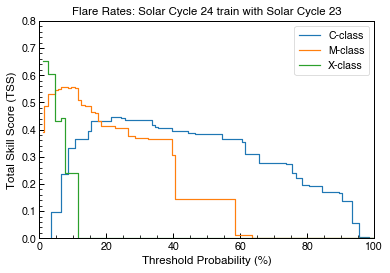

In [47]:
fig, ax = plt.subplots()
ax.plot(thresholds*100, tss_c, drawstyle="steps-mid", label="C-class")
ax.plot(thresholds*100, tss_m, drawstyle="steps-mid", label="M-class")
ax.plot(thresholds*100, tss_x, drawstyle="steps-mid", label="X-class")

ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.8)
ax.set_xlabel("Threshold Probability (%)")
ax.set_ylabel("Total Skill Score (TSS)")

ax.set_title("Flare Rates: Solar Cycle 24 train with Solar Cycle 23")

In [93]:
pred_val_c = np.array([1 if x >0.8 else 0 for x in pred_y_c])

In [94]:
print(np.sum(pred_val_c), np.sum(y_test_c))

735 2565


In [99]:
fpr, tpr, _ = metrics.roc_curve(y_test_c, pred_y_c)

In [100]:
fpr

array([0.00000000e+00, 2.11104074e-04, 1.37217648e-03, 7.38864260e-03,
       1.11885159e-02, 1.13996200e-02, 1.19273802e-02, 1.92104708e-02,
       1.94215748e-02, 2.35381043e-02, 2.53324889e-02, 2.57546971e-02,
       2.84990500e-02, 2.91323623e-02, 2.94490184e-02, 3.02934347e-02,
       3.13489550e-02, 3.43044121e-02, 3.48321723e-02, 3.74709732e-02,
       3.88431497e-02, 4.54929280e-02, 4.87650412e-02, 5.01372176e-02,
       8.23305890e-02, 8.26472451e-02, 8.66582225e-02, 9.03525438e-02,
       9.65801140e-02, 9.81633946e-02, 1.04602069e-01, 1.16423897e-01,
       1.17162761e-01, 1.20434874e-01, 1.21912603e-01, 1.29512350e-01,
       1.36056576e-01, 1.39750897e-01, 2.00232214e-01, 2.00337767e-01,
       2.50369432e-01, 2.53430441e-01, 3.22989234e-01, 3.28372388e-01,
       3.43466329e-01, 3.93709099e-01, 4.74561959e-01, 5.41798607e-01,
       6.79544015e-01, 8.46105130e-01, 8.78509605e-01, 9.96200127e-01,
       1.00000000e+00])

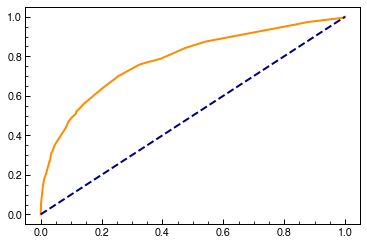

In [101]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

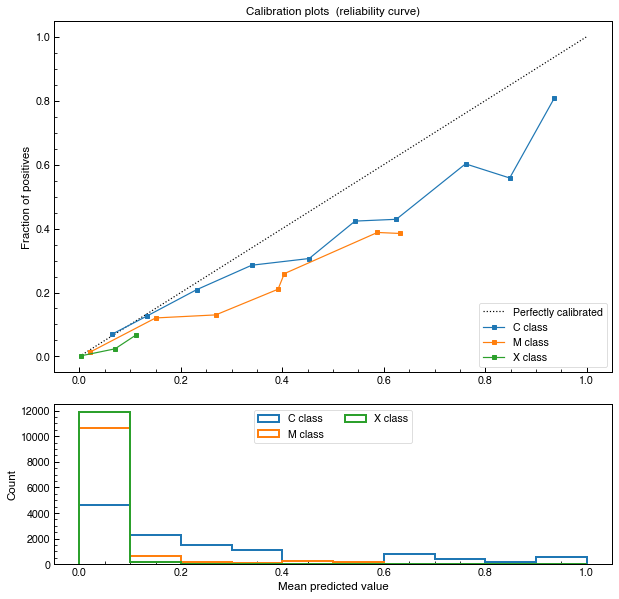

In [48]:
fraction_of_positives_c, mean_predicted_value_c = calibration_curve(y_test_c, pred_y_c, n_bins=10)
fraction_of_positives_m, mean_predicted_value_m = calibration_curve(y_test_m, pred_y_m, n_bins=10)
fraction_of_positives_x, mean_predicted_value_x = calibration_curve(y_test_x, pred_y_x, n_bins=20)


fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value_c, fraction_of_positives_c, "s-", label="C class")
ax1.plot(mean_predicted_value_m, fraction_of_positives_m, "s-", label="M class")
ax1.plot(mean_predicted_value_x, fraction_of_positives_x, "s-", label="X class")


ax2.hist(pred_y_c, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="C class")

ax2.hist(pred_y_m, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="M class")

ax2.hist(pred_y_x, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="X class")

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

## McEvol

In [50]:
def get_flare_rates_evol(data):
    """
    Determine flare rates for each McIntosh classification given an input 
    dataframe of AR-flare data.
    """

    flare_number_per_group = data.groupby(["evolution_mcint"])[["C+", "M+", "X+"]].sum().reset_index()
    total_per_group = data.groupby(["evolution_mcint"])["C+"].count().reset_index().rename(columns={"C+":"N"})
    flare_number_per_group["N"] = total_per_group["N"]

    flare_rates_per_group = flare_number_per_group.set_index("evolution_mcint")[["C+", "M+", "X+"]].div(flare_number_per_group["N"].values, axis=0)

    flare_number_per_group["C_rate"] = flare_rates_per_group["C+"].values
    flare_number_per_group["M_rate"] = flare_rates_per_group["M+"].values
    flare_number_per_group["X_rate"] = flare_rates_per_group["X+"].values

    return flare_number_per_group

In [51]:
flare_rates_evol = get_flare_rates_evol(data_ar_evol)

In [52]:
def get_predicted_flare_rates_evol(flare_rates, mcint):
    flare_rate_mcint = flare_rates[flare_rates["evolution_mcint"].isin([mcint])]
    if len(flare_rate_mcint)==0:
        return 0, 0, 0
    c_prob = 1-np.exp(-flare_rate_mcint["C_rate"].values[0])
    m_prob = 1-np.exp(-flare_rate_mcint["M_rate"].values[0])
    x_prob = 1-np.exp(-flare_rate_mcint["X_rate"].values[0])
    return c_prob, m_prob, x_prob

In [53]:
train_ar_evol = data_ar_evol[data_ar_evol["AR issue_date"]<="2009-01-01"]
test_ar_evol = data_ar_evol[data_ar_evol["AR issue_date"]>="2008-12-31"]

flare_rates_train_evol = get_flare_rates_evol(train_ar_evol)

X_test_evol = test_ar_evol["evolution_mcint"].values

In [54]:
y_test_c_evol = test_ar_evol["C+"].map(lambda x: 1 if x>0 else 0).values
y_test_m_evol = test_ar_evol["M+"].map(lambda x: 1 if x>0 else 0).values
y_test_x_evol = test_ar_evol["X+"].map(lambda x: 1 if x>0 else 0).values

In [55]:
pred_y_c_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[0] for x in X_test_evol]
pred_y_m_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[1] for x in X_test_evol]
pred_y_x_evol = [get_predicted_flare_rates_evol(flare_rates_train_evol, x)[2] for x in X_test_evol]

In [56]:
thresholds = np.linspace(0.01, 1, 100)
tss_c_evol, tss_m_evol, tss_x_evol = [], [], []
for t in thresholds:
    tss_c_evol.append(get_tss(y_test_c_evol, pred_y_c_evol, t))
    tss_m_evol.append(get_tss(y_test_m_evol, pred_y_m_evol, t))
    tss_x_evol.append(get_tss(y_test_x_evol, pred_y_x_evol, t))

Text(0.5, 1.0, 'Flare Rates Evol: Solar Cycle 24 train with Solar Cycle 23')

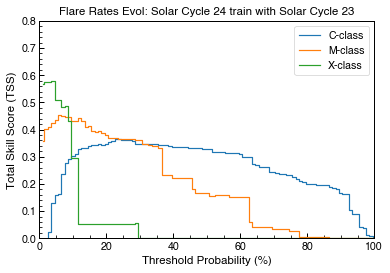

In [57]:
fig, ax = plt.subplots()
ax.plot(thresholds*100, tss_c_evol, drawstyle="steps-mid", label="C-class")
ax.plot(thresholds*100, tss_m_evol, drawstyle="steps-mid", label="M-class")
ax.plot(thresholds*100, tss_x_evol, drawstyle="steps-mid", label="X-class")


# ax.plot(thresholds*100, tss_c, drawstyle="steps-mid",ls="dashed", label="C-class")
# ax.plot(thresholds*100, tss_m, drawstyle="steps-mid",ls="dashed", label="M-class")
# ax.plot(thresholds*100, tss_x, drawstyle="steps-mid",ls="dashed", label="X-class")

ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 0.8)
ax.set_xlabel("Threshold Probability (%)")
ax.set_ylabel("Total Skill Score (TSS)")

ax.set_title("Flare Rates Evol: Solar Cycle 24 train with Solar Cycle 23")

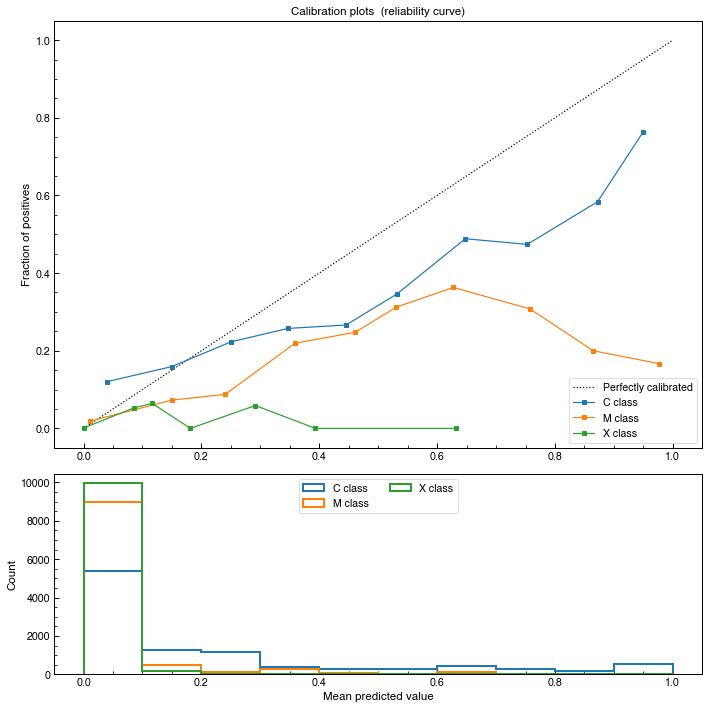

In [58]:
fraction_of_positives_c_evol, mean_predicted_value_c_evol = calibration_curve(y_test_c_evol, pred_y_c_evol, n_bins=10)
fraction_of_positives_m_evol, mean_predicted_value_m_evol = calibration_curve(y_test_m_evol, pred_y_m_evol, n_bins=10)
fraction_of_positives_x_evol, mean_predicted_value_x_evol = calibration_curve(y_test_x_evol, pred_y_x_evol, n_bins=20)


fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(mean_predicted_value_c_evol, fraction_of_positives_c_evol, "s-", label="C class")
ax1.plot(mean_predicted_value_m_evol, fraction_of_positives_m_evol, "s-", label="M class")
ax1.plot(mean_predicted_value_x_evol, fraction_of_positives_x_evol, "s-", label="X class")


ax2.hist(pred_y_c_evol, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="C class")

ax2.hist(pred_y_m_evol, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="M class")

ax2.hist(pred_y_x_evol, range=(0, 1), bins=10,
         histtype="step", lw=2,  label="X class")

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)
plt.tight_layout()

In [67]:
from metric_utils import *

In [ ]:
plot_roc_and_reliability_curve()